In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [3]:
TRAIN_DATA_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EPOCHS = 20
LR = 0.001
IMG_SIZE = 320
BATCH_SIZE = 32

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [4]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [5]:
def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

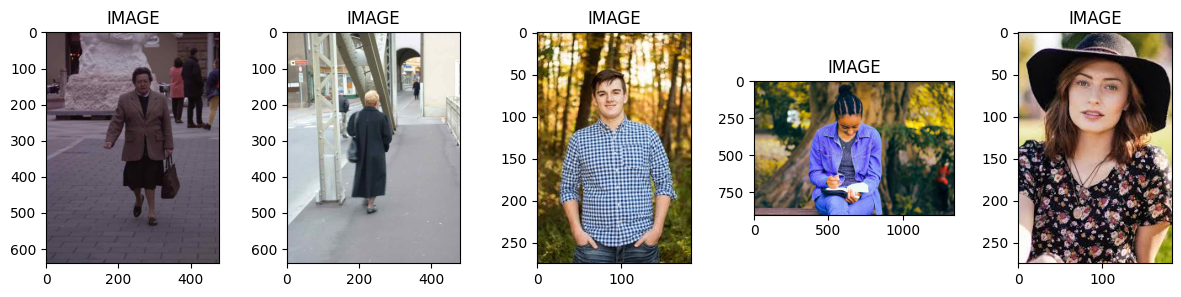

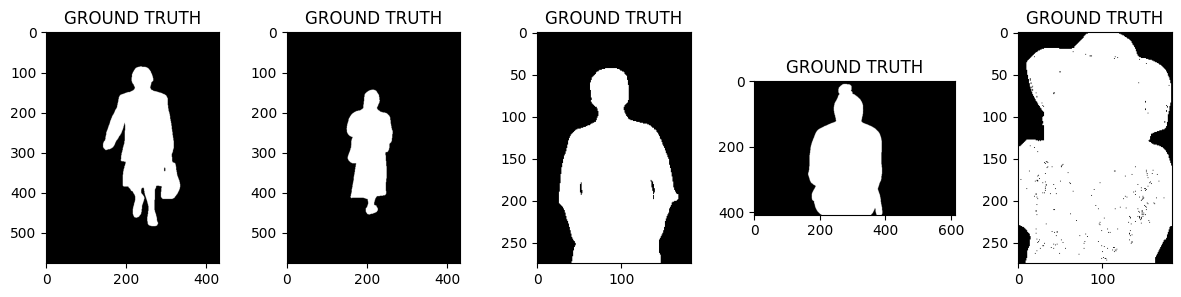

In [6]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]
generate_sample_images(sample)
generate_sample_masks(sample)

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

In [8]:
import albumentations as A
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [9]:
from torch.utils.data import Dataset
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)


        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [10]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [11]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 2


In [14]:
!pip install segmentation-models-pytorch

In [15]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [16]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [17]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gat

In [18]:
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [19]:
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [21]:
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.0514346063137054 Val Loss 2.1060283184051514


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


MODEL SAVED
 Epoch 2 Train Loss 0.5567510649561882 Val Loss 0.5690246522426605


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


MODEL SAVED
 Epoch 3 Train Loss 0.3416213095188141 Val Loss 0.3452586382627487


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


MODEL SAVED
 Epoch 4 Train Loss 0.2532294988632202 Val Loss 0.23846985399723053


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


 Epoch 5 Train Loss 0.24407638609409332 Val Loss 0.2445179969072342


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


MODEL SAVED
 Epoch 6 Train Loss 0.18877508491277695 Val Loss 0.2271086424589157


100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


 Epoch 7 Train Loss 0.17305660620331764 Val Loss 0.24521781504154205


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


 Epoch 8 Train Loss 0.13533193059265614 Val Loss 0.23065818846225739


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


MODEL SAVED
 Epoch 9 Train Loss 0.12773239891976118 Val Loss 0.21971888095140457


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


 Epoch 10 Train Loss 0.1358674531802535 Val Loss 0.2241508513689041


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


 Epoch 11 Train Loss 0.17539106216281652 Val Loss 0.22855831682682037


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


MODEL SAVED
 Epoch 12 Train Loss 0.19571480993181467 Val Loss 0.19684560596942902


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


 Epoch 13 Train Loss 0.1320683667436242 Val Loss 0.2166590839624405


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


 Epoch 14 Train Loss 0.14968594815582037 Val Loss 0.202925443649292


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


 Epoch 15 Train Loss 0.11217654682695866 Val Loss 0.22864747047424316


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


MODEL SAVED
 Epoch 16 Train Loss 0.10696453601121902 Val Loss 0.18100982904434204


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


MODEL SAVED
 Epoch 17 Train Loss 0.09568159841001034 Val Loss 0.16685081273317337


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


 Epoch 18 Train Loss 0.11281392443925142 Val Loss 0.17295747250318527


100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


 Epoch 19 Train Loss 0.09804996382445097 Val Loss 0.2220548763871193


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

 Epoch 20 Train Loss 0.0867206109687686 Val Loss 0.21101538836956024


In [31]:
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    return image, mask, pred_mask

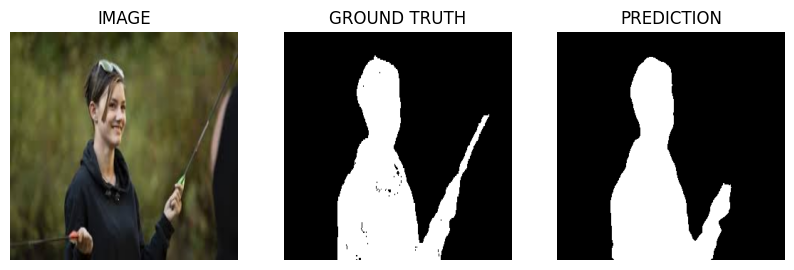

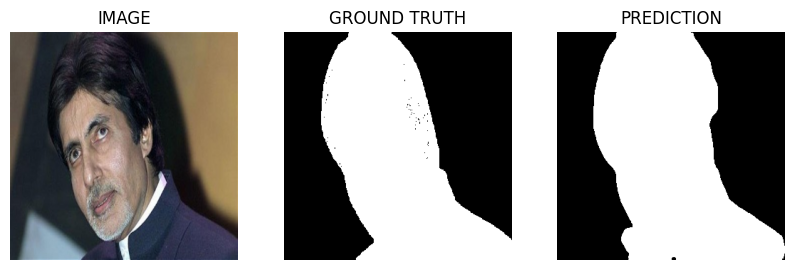

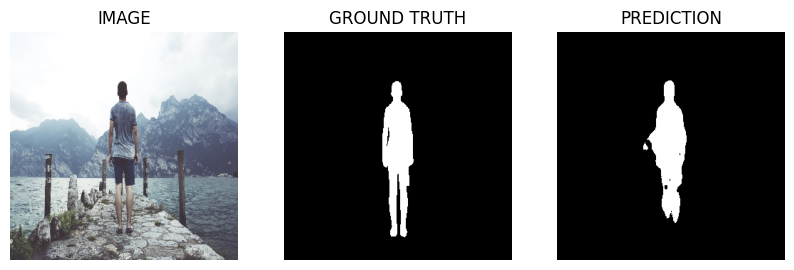

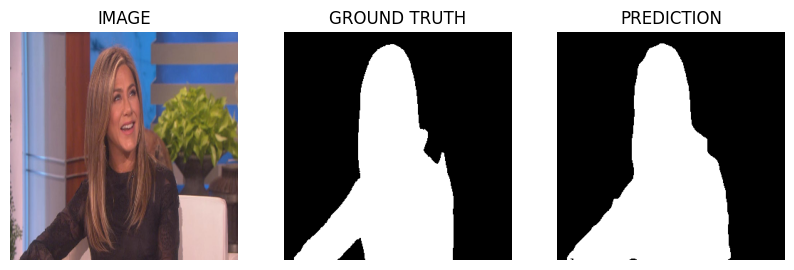

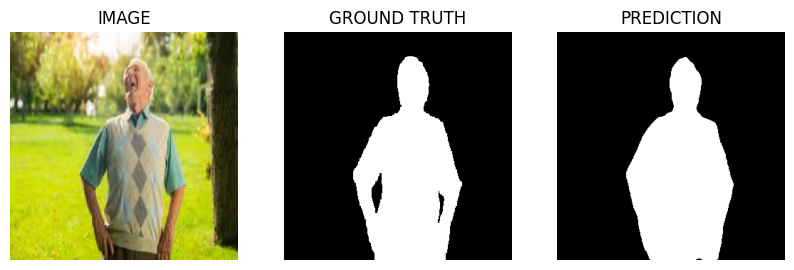

In [32]:
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');